## Download dataset from google bucket

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'xai-project-331112'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
bucket_name = 'xai_project'
!gsutil cp gs://{bucket_name}/credit* .

Copying gs://xai_project/credit_test.csv...
Copying gs://xai_project/credit_train.csv...
\ [2 files][ 19.4 MiB/ 19.4 MiB]                                                
Operation completed over 2 objects/19.4 MiB.                                     


In [ ]:
!ls

adc.json  credit_test.csv  credit_train.csv  sample_data


## XAI project. Part I

В первой части проекта использовались данные из соревнования Tinkoff Data Science Challenge. Задача состоит в необходимости классификации клиентов на тех, кто  выберет открыть кредитный счет в данном банке и тех, кто не откроет (задача бинарной классификации).

Tinkoff.ru работает с сетью магазинов электроники, в которой присутствуют и другие банки. Таблица содержит данные о кредитах на покупку электроники, которые были одобрены Tinkoff.ru. Необходимо предсказать, выберет ли покупатель кредит от Tinkoff.ru.

Исходная выборка содержит записи о 170746 клиентах, классифицированных на два класса: 0 - клиент не открыл кредитный счет в банке (140690 клиентов) и 1 - клиент открыл кредитный счет в банке (30056 клиентов). 

Учитывая очень большой объем данных (методы объяснения моделей работают на нем крайне медленно), а также дисбаланс классов, для целей данного проекта использовали подвыборку из 36000 элементов (по 18000 каждого класса).

Список признаков включает в себя:
 - client_id - идентификационный номер (категориальный признак);
 - gender - пол (категориальный признак);
 - age - возраст (количественный признак);
 - marital_status - семейный статус (категориальный признак);
 - job_position - сфера занятости (категориальный признак);
 - credit_sum - сумма кредита (количественный признак);
 - credit_month - срок кредитования (количественный признак);
 - tariff_id - идентификационный номер тарифа (категориальный признак);
 - score_shk - внутренняя скоринговая оценка (количественный признак);
 - education - образование (категориальный признак);
 - living_region - регион проживания (категориальный признак);
 - monthly_income - месячный заработок (количественный признак);
 - credit_count	 - количество кредитов у клиента (количественный признак);
 - overdue_credit_count	- количество просроченных кредитов у клиента (количественный признак);
 - Добавим собственный признак сумма месячного платежа (paym)
 - paym_bool_5000 - на основе paym введем бинарный признак, характеризующий, верно ли, что месячный платеж менее 5000 рублей.
 - Добавим собственный признак: какой процент составляет платеж от обще зп в месяц (pti)
 
 Целевая переменная: 
 - open_account_flag - факт открытия кредитного счета в данном банке.

## **Установка и импорт необходимых библиотек**

In [ ]:
!pip install dowhy
!apt install libgraphviz-dev
!pip install pygraphviz

     |████████████████████████████████| 123 kB 5.1 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-

In [ ]:
#@title Helper functions {display-mode: "form"}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

import os, sys

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

#logging.config.dictConfig(DEFAULT_LOGGING)

# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

#!pip install dowhy
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import pandas as pd
import pdb
from sklearn.pipeline import Pipeline
import sklearn.utils
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
#from sklearn.cross_validation import StratifiedKFold
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Загрузка и препроцессинг данных

In [ ]:
!wget https://raw.githubusercontent.com/Timrael/tinkoff/master/credit_train.csv
!wget https://raw.githubusercontent.com/Timrael/tinkoff/master/regres_credit_count.csv
!wget https://raw.githubusercontent.com/Timrael/tinkoff/master/regres_overdue_credit_count.csv

--2021-11-26 19:22:12--  https://raw.githubusercontent.com/Timrael/tinkoff/master/credit_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13294829 (13M) [text/plain]
Saving to: ‘credit_train.csv.1’

credit_train.csv.1  100%[===================>]  12.68M  --.-KB/s    in 0.1s    

2021-11-26 19:22:12 (112 MB/s) - ‘credit_train.csv.1’ saved [13294829/13294829]

--2021-11-26 19:22:13--  https://raw.githubusercontent.com/Timrael/tinkoff/master/regres_credit_count.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 351574 (343K

In [ ]:
data_train_path = '/content/credit_train.csv'
data_test_path = '/content/credit_test.csv'

In [ ]:
data = pd.read_csv(data_train_path, sep = ';', encoding='cp1251')
data.shape

In [ ]:
data.head()

client_id gender  age  ... credit_count overdue_credit_count open_account_flg
0          1      M   48  ...          1.0                  1.0                0
1          2      F   28  ...          2.0                  0.0                0
2          3      M   32  ...          5.0                  0.0                0
3          4      F   27  ...          2.0                  0.0                0
4          5      M   45  ...          1.0                  0.0                0

[5 rows x 15 columns]

In [ ]:
#генерирование подвыборки из 36000 объектов (по 18000 каждого класса)
N = 18*10**3
mask = data.open_account_flg == 1
new_dataset_1 = data[mask]
new_dataset_1_train, new_dataset_1_test, y_tr, y_ts = train_test_split(
    new_dataset_1,
    new_dataset_1.open_account_flg,
    test_size=0.3,
    random_state=42
)
new_dataset_1_train = new_dataset_1_train[:N]

mask = data.open_account_flg == 0
new_dataset_0 = data[mask]
new_dataset_0_train, new_dataset_1_test, y_tr, y_ts = train_test_split(
    new_dataset_0,
    new_dataset_0.open_account_flg,
    test_size=0.5,
    random_state=42
)
new_dataset_0_train = new_dataset_0_train[:N]

data = pd.concat([new_dataset_0_train, new_dataset_1_train], axis=0)
data.shape

In [ ]:
data.drop('client_id', axis=1, inplace=True)

In [ ]:
import re

# увеличиваем максимальное количество
# отображаемых строк
pd.options.display.max_rows = 310

# уникальные значения переменной living_region
# записываем в отдельный объект regions
regions = data['living_region'].unique()

# создаем серию, у которой в качестве значений и индексных
# меток будут выступать уникальные значения переменной
# living_region, записанные в regions
regions = pd.Series(data=regions, index=regions, name='regions')

stopwrds = set(['ОБЛ', 'ОБЛАСТЬ', 'РЕСП', 'РЕСПУБЛИКА',
                'КРАЙ', 'Г', 'АО', 'АОБЛ', 'АВТОНОМНАЯ'])

# пишем функцию для предобработки значений серии
def clean_region(x):
    x = re.sub('[.,]+', ' ', str(x))
    wrds = x.split(' ')
    wrds_new = []
    for w in wrds:
        if not w in stopwrds:
            wrds_new.append(w)
    x = ''.join(wrds_new)
    return x
# применяем функцию к нашей серии
regions = regions.map(clean_region)

# вносим финальные корректировки в regions
regions['ЧУКОТСКИЙ АO'] = 'ЧУКОТСКИЙ'
regions['ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА -'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions['РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions['РЕСПУБЛИКАТАТАРСТАН'] = 'ТАТАРСТАН'
regions['ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'] = 'МОСКОВСКАЯ'
regions['ПЕРМСКАЯ ОБЛ'] = 'ПЕРМСКИЙ'
regions['ОРЁЛ'] = 'ОРЛОВСКАЯ'
regions['Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions['МЫТИЩИНСКИЙ Р-Н'] = 'МОСКОВСКАЯ'
regions['МОСКОВСКИЙ П'] = 'МОСКОВСКАЯ'
regions['КАМЧАТСКАЯ ОБЛАСТЬ'] = 'КАМЧАТСКИЙ'
regions['ДАЛЬНИЙ ВОСТОК'] = 'МОСКОВСКАЯ'
regions['ДАЛЬНИЙВОСТОК'] = 'МОСКОВСКАЯ'
regions['ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н'] = 'ВЛАДИМИРСКАЯ'
regions['ГОРЬКОВСКАЯ ОБЛ'] = 'НИЖЕГОРОДСКАЯ'
regions['ЭВЕНКИЙСКИЙ АО'] = 'КРАСНОЯРСКИЙ'
regions['ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['АО ХАНТЫ-МАНСИЙСКИЙ-ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['СЕВ. ОСЕТИЯ - АЛАНИЯ'] = 'СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ'
regions['РЕСП. САХА (ЯКУТИЯ)'] = 'САХА/ЯКУТИЯ/'
regions['РЕСПУБЛИКА САХА'] = 'САХА/ЯКУТИЯ/'
regions['ДАЛЬНИЙВОСТОК'] = 'МОСКОВСКАЯ'
regions['САХА'] = 'САХА/ЯКУТИЯ/'

regions['98'] = 'САНКТ-ПЕТЕРБУРГ'
regions['74'] = 'ЧЕЛЯБИНСКАЯ'
regions['РОССИЯ'] = 'МОСКОВСКАЯ'
regions['МОСКВОСКАЯ'] = 'МОСКОВСКАЯ'
regions['МОСКВОСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions['ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions['Г. ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions['БРЯНСКИЙ'] = 'БРЯНСКАЯ'

# заменяем исходные категории переменной
# living_region на новые
data['living_region'] = data['living_region'].map(regions)

# преобразуем указанные переменные в тип object
for i in ['tariff_id', 'open_account_flg']:
    data[i] = data[i].astype('object')

# в указанных переменных заменяем запятые на точки и
# преобразуем в тип float
for i in ['credit_sum', 'score_shk']:
    data[i] = data[i].str.replace(',', '.').astype('float')

# создаем словарь, в котором ключом является старое
# название категории, значением – новое название
# категории
d = {'M':'Male', 'F':'Female'}
# передаем словарь в метод map
data['gender'] = data['gender'].map(d)

# выводим частоты категорий по каждой
# категориальной переменной
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']

# записываем указанные категории переменной
# job_position в отдельную категорию OTHER
data.at[data['job_position'] == 'PNV', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'PNS', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'HSK', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'INV', 'job_position'] = 'OTHER'
data.at[data['job_position'] == 'ONB', 'job_position'] = 'OTHER'

# все категории переменной tariff_id с частотой
# менее 55 наблюдений записываем в отдельную
# категорию 1.99
data.loc[data['tariff_id'].value_counts()[data['tariff_id']].values < 55,
'tariff_id'] = 1.99
# на основе категориальной переменной tariff_id создаем
# количественную переменную tariff
data['tariff'] = data['tariff_id'].astype('float')
# заменим точки на символы подчеркивания
data['tariff_id'] = data['tariff_id'].astype('str').str.replace('.', '_')

# создаем серию, у которой значениями будут частоты
# категорий переменной living_region
region_series = data['living_region'].value_counts()

# создаем булеву маску, если частота категории меньше 0.029,
# будет возвращено значение TRUE, в противном случае
# будет возвращено значение FALSE
mask = (region_series/region_series.sum() * 100).lt(0.029)

# с помощью функции np.where мы все категории, по которым возвращено
# значение TRUE, заменим на категорию OTHER, в противном случае
# оставим категории неизменными
data['living_region'] = np.where(data['living_region'].isin(region_series[mask].index),
                                 'OTHER', data['living_region'])


In [ ]:
#========================== лень! ==========================
# train = data.copy() # лень корректировать!
#========================== лень! ==========================


train, test, labels_train, labels_test = train_test_split(data,
                                        data.open_account_flg,
                                        test_size=0.16,
                                        random_state=42,
                                        stratify=data.open_account_flg
                                        )
train.shape

In [ ]:

# заполняем пропуски в переменной age медианой
train['age'].fillna(train['age'].median(), inplace=True)
test['age'].fillna(train['age'].median(), inplace=True)

# заполняем пропуски в переменных credit_sum, score_shk
# и monthly_income медианами
for i in ['credit_sum', 'score_shk', 'monthly_income']:
    train[i].fillna(train[i].median(), inplace=True)
    test[i].fillna(train[i].median(), inplace=True)

# заполняем пропуски в переменных credit_count,
# overdue_credit_count -1
for i in ['credit_count', 'overdue_credit_count']:
    train[i].fillna(-1, inplace=True)
for i in ['credit_count', 'overdue_credit_count']:
    test[i].fillna(-1, inplace=True)

# выполняем импутацию пропусков модой
train['marital_status'] = train['marital_status'].fillna('MAR')
test['marital_status'] = test['marital_status'].fillna('MAR')

# выполняем импутацию пропусков модой
train['education'].fillna(train['education'].value_counts().index[0], inplace=True)
test['education'].fillna(train['education'].value_counts().index[0], inplace=True)

# создаем переменную paym, которая
# является отношением выданной суммы кредита
# (credit_sum) к сроку кредита (credit_month),
# то есть ежемесячной суммой кредита
#train['paym'] = train['credit_sum'] / train['credit_month']
#test['paym'] = test['credit_sum'] / test['credit_month']
train['paym'] = (train['credit_sum'] * (1 + train['credit_month'] * train['tariff'] / 100)) / train['credit_month']
test['paym'] = (test['credit_sum'] * (1 + test['credit_month'] * test['tariff'] / 100)) / test['credit_month']

# создаем переменную pti, которая является
# отношением ежемесячной суммы кредита
# (paym) к ежемесячному заработку
# (monthly_income)
train['pti'] = train['paym'] / train['monthly_income']
test['pti'] = test['paym'] / test['monthly_income']
# заменяем бесконечные значения на 1
train['pti'].replace([np.inf, -np.inf], 1, inplace=True)
test['pti'].replace([np.inf, -np.inf], 1, inplace=True)

# отключаем экспоненциальную запись
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.head()
# создаем новые переменные, возведя некоторые
# количественные переменные в квадрат
train['tariff_sq'] = train['tariff']**2
test['tariff_sq'] = test['tariff']**2
train['age_sq'] = train['age']**2
test['age_sq'] = test['age']**2
train['credit_sum_sq'] = train['credit_sum']**2
test['credit_sum_sq'] = test['credit_sum']**2
train['score_sq'] = train['score_shk']**2
test['score_sq'] = test['score_shk']**2
train['income_sq'] = train['monthly_income']**2
test['income_sq'] = test['monthly_income']**2
train['credit_month_sq'] = train['credit_month']**2
test['credit_month_sq'] = test['credit_month']**2
train['credit_count_sq'] = train['credit_count']**2
test['credit_count_sq'] = test['credit_count']**2

# выполняем дамми-кодирование переменной
# marital_status по методу неполного ранга
dummies_unfull_rank_marital_status = pd.get_dummies(train['marital_status'])

# выполняем дамми-кодирование переменной
# marital_status по методу полного ранга
dummies_full_rank_marital_status = pd.get_dummies(train['marital_status'],
                                                  drop_first=True)

train.head()

gender  age  ... credit_month_sq credit_count_sq
130570    Male   24  ...             100          16.000
54950   Female   46  ...             100           1.000
145969    Male   49  ...             100           1.000
39605     Male   33  ...             144           1.000
93990     Male   33  ...             144          16.000

[5 rows x 24 columns]

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30240 entries, 130570 to 87826
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                30240 non-null  object 
 1   age                   30240 non-null  int64  
 2   marital_status        30240 non-null  object 
 3   job_position          30240 non-null  object 
 4   credit_sum            30240 non-null  float64
 5   credit_month          30240 non-null  int64  
 6   tariff_id             30240 non-null  object 
 7   score_shk             30240 non-null  float64
 8   education             30240 non-null  object 
 9   living_region         30240 non-null  object 
 10  monthly_income        30240 non-null  float64
 11  credit_count          30240 non-null  float64
 12  overdue_credit_count  30240 non-null  float64
 13  open_account_flg      30240 non-null  object 
 14  tariff                30240 non-null  float64
 15  paym          

In [ ]:
dataset = train.copy()

In [ ]:
dataset.open_account_flg.value_counts()

1    15120
0    15120
Name: open_account_flg, dtype: int64

In [ ]:
dataset['has_overdue_credits'] = dataset['overdue_credit_count'].apply(lambda x : True if x > 0 else (False))
dataset['is_married'] = dataset['marital_status'].apply(lambda x : True if x in {'MAR', 'CIV'} else (False))
dataset['higher_education'] = dataset['education'].apply(lambda x : True if x in {'GRD', 'PGR', 'ACD'} else (False))
dataset = dataset.reindex(columns=[
                                   'gender', 
                                   'age', 
                                   'marital_status', 
                                   'is_married', 
                                   'job_position',
                                   'credit_sum', 
                                   'credit_month', 
                                   'tariff_id', 
                                   'score_shk', 
                                   'education', 
                                   'higher_education', 
                                   'living_region',
                                   'monthly_income',
                                   'credit_count', 
                                   'overdue_credit_count', 
                                   'has_overdue_credits', 
                                   'open_account_flg',
                                   'tariff', 
                                   'paym', 
                                   'pti',
                                   ]
                          )

In [ ]:
test['has_overdue_credits'] = test['overdue_credit_count'].apply(lambda x : True if x > 0 else (False))
test['is_married'] = test['marital_status'].apply(lambda x : True if x in {'MAR', 'CIV'} else (False))
test['higher_education'] = test['education'].apply(lambda x : True if x in {'GRD', 'PGR', 'ACD'} else (False))
test = test.reindex(columns=[
                                   'gender', 
                                   'age', 
                                   'marital_status', 
                                   'is_married', 
                                   'job_position',
                                   'credit_sum', 
                                   'credit_month', 
                                   'tariff_id', 
                                   'score_shk', 
                                   'education', 
                                   'higher_education', 
                                   'living_region',
                                   'monthly_income',
                                   'credit_count', 
                                   'overdue_credit_count', 
                                   'has_overdue_credits', 
                                   'open_account_flg',
                                   'tariff', 
                                   'paym', 
                                   'pti',
                                   ]
                          )

In [ ]:
dataset.paym.value_counts()

8002.724     36
2635.636     30
1771.806     29
5288.208     28
1180.929     26
             ..
2610.381      1
2309.310      1
10421.679     1
3158.236      1
1367.625      1
Name: paym, Length: 24275, dtype: int64

In [ ]:
dataset.paym.describe()

count   30240.000
mean     2694.854
std      1719.304
min       184.386
25%      1558.241
50%      2194.262
75%      3253.771
max     41285.567
Name: paym, dtype: float64

In [ ]:
dataset[["paym", "open_account_flg"]].groupby("open_account_flg").agg("mean")

paym
open_account_flg         
0                2888.609
1                2501.100

In [ ]:
dataset[["paym", "open_account_flg"]].groupby("open_account_flg").agg("median")

paym
open_account_flg         
0                2320.478
1                2094.274

In [ ]:
dataset['paym_bool_5000'] = dataset["paym"].apply(lambda x: False if x > 5000 else True)
dataset['paym_bool_5000'].value_counts()

True     26896
False     3344
Name: paym_bool_5000, dtype: int64

In [ ]:
test['paym_bool_5000'] = test["paym"].apply(lambda x: False if x > 5000 else True)
test['paym_bool_5000'].value_counts()

True     5110
False     650
Name: paym_bool_5000, dtype: int64

## 1. Поиск причинно-следственных связей с заданной графовой моделью

In [ ]:
dataset.columns

Index(['gender', 'age', 'marital_status', 'is_married', 'job_position',
       'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education',
       'higher_education', 'living_region', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'has_overdue_credits', 'open_account_flg',
       'tariff', 'paym', 'pti', 'paym_bool_5000'],
      dtype='object')

In [ ]:
dataset.columns[16]

'open_account_flg'

In [ ]:
len(dataset.columns)

После препроцессинга получили следующие данные:

In [ ]:
dataset=dataset[['gender', 'age', 'marital_status', 'is_married', 'job_position', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education', 'higher_education', 'living_region', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'has_overdue_credits', 'tariff', 'paym', 'pti', 'paym_bool_5000', 'open_account_flg']]
dataset

gender  age marital_status  ...   pti paym_bool_5000  open_account_flg
130570    Male   24            UNM  ... 0.084           True                 1
54950   Female   46            UNM  ... 0.083           True                 1
145969    Male   49            MAR  ... 0.066           True                 0
39605     Male   33            UNM  ... 0.205           True                 1
93990     Male   33            MAR  ... 0.027           True                 0
...        ...  ...            ...  ...   ...            ...               ...
102510    Male   42            MAR  ... 0.048           True                 1
156093  Female   44            MAR  ... 0.086           True                 1
164365  Female   39            UNM  ... 0.038           True                 1
169582    Male   28            DIV  ... 0.110          False                 0
87826     Male   29            MAR  ... 0.124          False                 1

[30240 rows x 21 columns]

In [ ]:
dataset.shape

### 1.1. Построение графа зависимостей признаков на основе предварительных предположений.

В данной части оценим влияние размера ежемесячного платежа на вероятность того, что Клиент выберет кредит в Tinkoff.ru. В качестве порогового значения возьмем 5000 руб. То есть предполагаем, что если ежемесячный платеж окажется меньше 5000 руб., то это повысит вероятность того, что клиент откроет счет в Tinkoff.ru.

При анализе влияния признаков на целевую переменную необходимо помнить, что в рассматриваемой задаче известно, что со стороны банка все кредитные заявки уже одобрены, то есть именно Клиент принимает решение, выберет он кредит от Tinkoff.ru или от другого банка.

Исходя из общих представлений о процессе одобрения кредита, а также личного опыта получения кредитов и выбора между банками, можно сделать следующие предположения взаимосвязях между признаками:
 - overdue_credit_count (количество просроченных кредитов), education (образование),  marital_status (семейный статус), gender (пол), age(возраст), monthly_income (месячный доход), job_position (сфера занятости), количество кредитов(credit_count) влияют на score_shk (внутреннюю скоринговую оценку);
 - score_shk (внутренняя скоринговая оценка) влияет на tariff_id (идентификатор тарифа) - то есть чем хуже получается рассчитанный внутренний рейтинг клиента, тем выше будет процентная ставка; Также на размер тарифа может влиять регион проживания.
 - tariff_id(идентификатор тарифа), credit_month (срок кредита), credit_sum (сумма кредита) влияют на размер платежа.

 - education (образование) и job_position	(сфера занятости) влияют на monthly_income	(месячный доход);
 
 - Размер ежемесячного платежа может оказывать влияние на то, согласится ли клиент оформить кредит (open_account_flg)


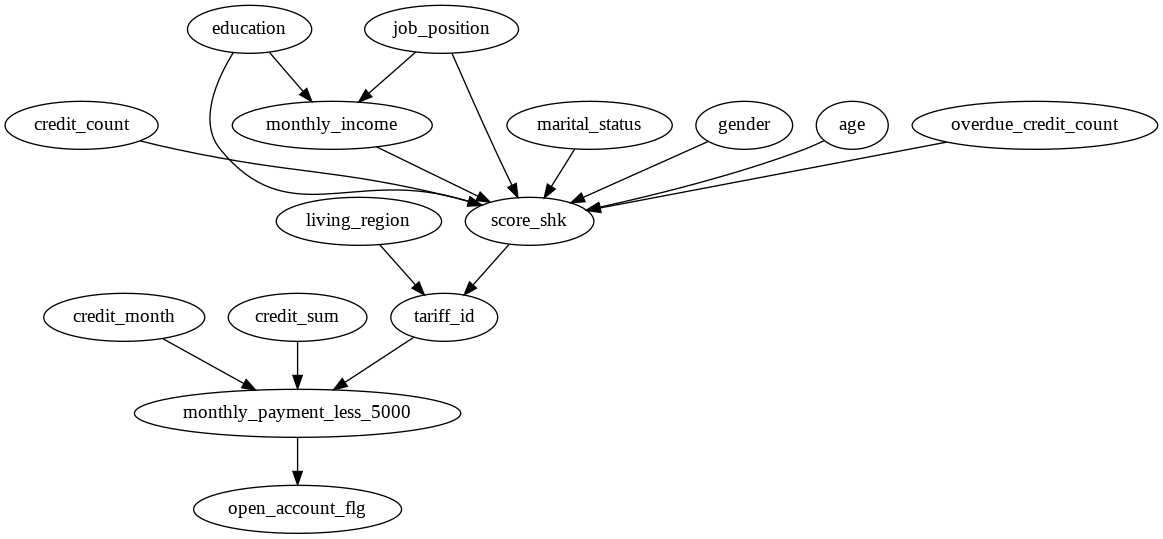

In [ ]:
# paym_bool_5000
# Setting a causal graph
causal_graph = """digraph {
score_shk[label = "score_shk"];
tariff_id[label = "tariff_id"];
credit_month[label = "credit_month"];
credit_count[label = "credit_count"];
credit_sum[label = "credit_sum"];
education[label = "education"];
living_region[label = "living_region"];
monthly_income[label = "monthly_income"];
marital_status[label = "marital_status"];
gender[label = "gender"];
age[label = "age"];
job_position[label = "job_position"];
overdue_credit_count[label = "overdue_credit_count"];
open_account_flg[label = "open_account_flg"];
paym_bool_5000[label = "monthly_payment_less_5000"];

{education, marital_status, gender, age, monthly_income, job_position,  credit_count, credit_count, overdue_credit_count} -> score_shk;
{score_shk, living_region}-> {tariff_id}; 
{education, job_position} -> monthly_income;

{credit_sum, tariff_id,  credit_month} -> paym_bool_5000;
{paym_bool_5000} -> open_account_flg;

}"""

model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='paym_bool_5000',
        outcome='open_account_flg')
model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

Построим модель оценки влияния анализируемого признака ("paym_bool_5000") на целевую переменную.

In [ ]:
import statsmodels
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="paym_bool_5000",
        outcome='open_account_flg')

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
print(estimate)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(open_account_flg|overdue_credit_count,age,score_
d[paym_bool_5000]                                                             

                                                                              
shk,monthly_income,gender,job_position,credit_count,education,marital_status,l
                                                                              

              
iving_region))
              
Estimand assumption 1, Unconfoundedness: If U→{paym_bool_5000} and U→open_account_flg then P(open_account_flg|paym_bool_5000,overdue_credit_count,age,score_shk,monthly_income,gender,job_position,credit_count,education,marital_status,living_region,U) = P(open_account_flg|paym_bool_5000,overdue_credit_count,age,score_shk,monthly_income,gender,job_position,credit_count,education,mari

Учитывая полученное значение Mean value: 0.196, можно сделать вывод что paym_bool_5000 (сумма платежа менее 5000р. в месяц) оказывает слабое положительное влияние на решение клиента взять кредит в данном банке. 

Это ожидаемый результат: мы и предполагали, что если ежемесячная сумма платежа менее 5000 руб., то это повышает шансы на выбор кредита Tinkoff.ru.

### 1.2. Применение “refutation” методов

Для тестирования полученной модели применим следующие refuration методы:
 -  **Random Common Cause:** добавим случайные величины в качестве общих причин анализируемой переменной ("paym_bool_X") и целевой переменной ("open_account_flg"). Если при добавлении таких общих причин результат применения модели не изменится, значит, мы корректно оценили влияние рассматриваемой переменной на результат.
 - **Placebo Treatment:** в качестве переменной treatment подставим случайную величину и оценим, как изменится оценка влияния. Если оценка влияния не изменится, это будет говорить, что наш анализ некорректный. Ожидаем, что при изменении treatment на случайную величину оценка влияния будет нулевой.
 - **Data Subsets Validation:** проанализируем, как изменится оценка влияния, если мы заменим наш датасет случайным подмножеством. Если не изменится, значит, оценка влияния произведена корректно.

**Random Common Cause:**

In [ ]:
refute1_results = model.refute_estimate(identified_estimand, estimate,
        method_name = "random_common_cause")
print(refute1_results)
print(estimate)

Refute: Add a Random Common Cause
Estimated effect:0.19591103536005264
New effect:0.19591231855456068

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(open_account_flg|overdue_credit_count,age,score_
d[paym_bool_5000]                                                             

                                                                              
shk,monthly_income,gender,job_position,credit_count,education,marital_status,l
                                                                              

              
iving_region))
              
Estimand assumption 1, Unconfoundedness: If U→{paym_bool_5000} and U→open_account_flg then P(open_account_flg|paym_bool_5000,overdue_credit_count,age,score_shk,monthly_income,gender,job_position,credit_count,education,marital_status

Анализ степени влияния не изменился, следовательно можно сделать вывод, что метод "Random Common Cause" подтверждает корректность оценки важности.

**Placebo Treatment**

In [ ]:
#Randomly assigns any covariate as a treatment and re-runs the analysis. If our 
# assumptions were correct then this newly found out estimate should go to 0.
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.19591103536005264
New effect:0.0005270639934406
p value:0.43



Так как новая оценка эффекта близка к нулю (что и ожидалось), делаем вывод, что первоначальная оценка корректна.

**Data Subsets Validation**

In [ ]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:0.19591103536005264
New effect:0.19642862753102414
p value:0.45



Оценка влияния, рассчитанная на подмножествах исходного датасета, не изменилась существенным образом относительно оценки на всем датасете. Т.о. можем сделать вывод, что данная оценка корректна.

Таким образом, мы построили граф зависимостей имеющихся признаков и целевой переменной, а также проанализировали влияние суммы месячного платежа на открытие нового кредитного счета. Первоначально предполагалось, что влияние будет положительным. При сумме месячного платежа менее 5000 руб. более вероятно, что клиент возьмет кредит. 

Анализ с помощью инструментов WhyDo показал достаточно слабое влияние данного признака на возможность того, что клиент откроет кредит.


Следует отметить, что в ходе работы мы анализировали влияние различных признаков на целевую переменную:
 - pti_bool_X(процент кредита от зп равный Х) при различных значениях Х, 
 - paym_bool_X(сумма месячного платежа не более Х) при разных Х,
 - уровень образования (наличие высшего образования),
 - семейное положение (женат/неженат),
 - наличие хотя бы одного просроченного кредита.
 
Из всех проанализированных признаков сумма ежемесячного платежа при пороговом значении 5000 руб. оказалась наиболее влияющей на целевую переменную.

Кроме этого, при анализе признаков было выявлено, что внесение каких-либо изменений в первоначальный график зависимостей оказывает существенное влияние на результат работы модели (оценка влияния может колебаться от 0 до 0,196). 

### 1.3. Поиск причинно-следственных связей с графовой моделью, используемой по умолчанию

Теперь проанализируем влияние того же признака (сумме месячного платежа менее 5000 р, paym_bool_5000) на целевую переменную на основе графа, построенного по умолчанию:

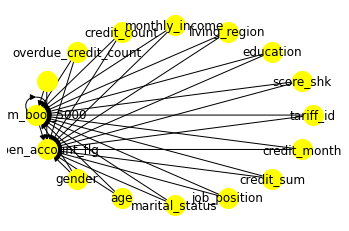

In [ ]:
xs = ""
for i in ['gender', 'age', 'marital_status', 'job_position',
       'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education',
       'living_region', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'paym_bool_5000']:
    xs += (str(i)+"+")

model=CausalModel(
        data = dataset,
        treatment='paym_bool_5000',
        outcome='open_account_flg',
        common_causes=xs.split('+')
        )

model.view_model()

In [ ]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(open_account_flg|credit_month,overdue_credit_cou
d[paym_bool_5000]                                                             

                                                                              
nt,age,score_shk,monthly_income,gender,job_position,credit_sum,marital_status,
                                                                              

                                                
education,tariff_id,living_region,credit_count))
                                                
Estimand assumption 1, Unconfoundedness: If U→{paym_bool_5000} and U→open_account_flg then P(open_account_flg|paym_bool_5000,credit_month,overdue_credit_count,age,score_shk,monthly_income,gender,job_position,credit_sum,marital_status,education,tariff_id,living_region,credit_count,

In [ ]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(open_account_flg|credit_month,overdue_credit_cou
d[paym_bool_5000]                                                             

                                                                              
nt,age,score_shk,monthly_income,gender,job_position,credit_sum,marital_status,
                                                                              

                                                
education,tariff_id,living_region,credit_count))
                                                
Estimand assumption 1, Unconfoundedness: If U→{paym_bool_5000} and U→open_account_flg then P(open_account_flg|paym_bool_5000,credit_month,overdue_credit_count,age,score_shk,monthly_income,gender,job_position,credit_sum,marital_status

В случае графа, построенного по умолчанию, оценка влияния анализируемого признака на целевую переменную близка к нулю. Из этого можно сделать вывод, что внесение изначальных предположений о причинно-следственных связях между признаками оказывает существенное влияние на результаты работы модели. Как выше уже отмечалось, и при внесении изменений в граф зависимости, основанный на изначальных предположениях, оценка влияния может варьюроваться достаточно существенно.

### Применим те же самые “refutation” методы

**Random Common Cause:**


In [ ]:
refute1_results = model.refute_estimate(identified_estimand, estimate,
        method_name = "random_common_cause")
print(refute1_results)
print(estimate)

Refute: Add a Random Common Cause
Estimated effect:-0.03394127079393919
New effect:-0.02506831596192707

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(open_account_flg|credit_month,overdue_credit_cou
d[paym_bool_5000]                                                             

                                                                              
nt,age,score_shk,monthly_income,gender,job_position,credit_sum,marital_status,
                                                                              

                                                
education,tariff_id,living_region,credit_count))
                                                
Estimand assumption 1, Unconfoundedness: If U→{paym_bool_5000} and U→open_account_flg then P(open_account_flg|paym_bool_5000,cre

Оценка влияния не изменилась. Random Common Cause подтверждает корректность работы метода.

**Placebo Treatment**


In [ ]:
#Randomly assigns any covariate as a treatment and re-runs the analysis. If our 
# assumptions were correct then this newly found out estimate should go to 0.
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.03394127079393919
New effect:7.246311123998161e-05
p value:0.49



Оценка эффекта близка к нулю. Placebo Treatment подтверждает корректность работы метода.

**Data Subsets Validation**


In [ ]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


Refute: Use a subset of data
Estimated effect:-0.03394127079393919
New effect:-0.03199583946903093
p value:0.44



Data Subsets Validation также подтверждает корректность работы метода.

Таким образом, результаты, полученные с использованием графа по умолчанию, отличаются от тех, которые получены на основе графа, построенного на основе предположений о предметной области. В первом случае (на основе предположений) мы получили, что размер ежемесячного платежа менее 5000 руб. оказывает хоть и слабое, но все же положительное влияние на открытие кредита в Tinkoff.ru. При использовании графа по умолчанию влияние нулевое.

Кроме того, при внесении изменений в граф на основе предположений расчетное значение важности признака может существенно колебаться.

Считаем, что данный пример является хорошей иллюстрацией того, что для качественной интерпретации данных необходимы грубокие знания в предметной области. Чем корректнее предположения, внесенные в основу работы модели, тем корректнее будет полученный результат.

Теперь построим модели черного ящика и попытаемся понять их работу.

## 2. Обучение моделей черного ящика

## Импорт необходимых библиотек

In [ ]:
import pandas as pd
import pdb
from sklearn.pipeline import Pipeline
import sklearn.utils
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
#from sklearn.cross_validation import StratifiedKFold
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Activation, GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow

## Обучение моделей черного ящика.

In [ ]:
feature_names_wich_target = dataset.columns
print(feature_names_wich_target)
feature_names = np.delete(feature_names_wich_target, [16]) #target is "open_account_flg" pos - 16
#feature_names = np.delete(feature_names_wich_target, [-1])
feature_names

Index(['gender', 'age', 'marital_status', 'is_married', 'job_position',
       'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education',
       'higher_education', 'living_region', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'has_overdue_credits', 'open_account_flg',
       'tariff', 'paym', 'pti', 'paym_bool_5000'],
      dtype='object')


Index(['gender', 'age', 'marital_status', 'is_married', 'job_position',
       'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education',
       'higher_education', 'living_region', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'has_overdue_credits', 'tariff', 'paym', 'pti',
       'paym_bool_5000'],
      dtype='object')

In [ ]:
labels = dataset["open_account_flg"]
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
dataset = dataset[feature_names].values

In [ ]:
categorical_features = ['gender', 'marital_status', 'job_position', 'tariff_id', 'education', 'living_region', 'has_overdue_credits', 'is_married', 'higher_education', 'paym_bool_5000']
categorical_features_indices =  [0, 2, 4, 7, 9, 11, 15, 3, 10, 19]

In [ ]:
categorical_names = {}
for feature in categorical_features_indices:
  le = LabelEncoder()
  le.fit(dataset[:, feature])
  dataset[:, feature] = le.transform(dataset[:, feature])
  categorical_names[feature] = le.classes_

In [ ]:
from sklearn.compose import ColumnTransformer 
encoder = ColumnTransformer([("enc", sklearn.preprocessing.OneHotEncoder(), categorical_features_indices)], remainder = 'passthrough')

In [ ]:
np.random.seed(1)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(dataset, labels, train_size=0.80)

In [ ]:
encoder.fit(dataset)
encoded_train = encoder.transform(train)

In [ ]:
encoded_train.shape

In [ ]:
train.shape

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



def tune_model(clf_name, clf, param_grid, X_train, y_train):
    CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='roc_auc')
    print('TUNNING ' + clf_name)
    CV_rfc.fit(X_train, y_train)
    print(CV_rfc.best_params_)
    print('Best auc = ' + str(CV_rfc.best_score_))

def fit(clf_name, clf, X_train, y_train):
    print('Fitting ' + clf_name)
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)

    if hasattr(clf, "predict_proba"):
        train_predprob = clf.predict_proba(X_train)[:, 1]
    else:  # use decision function
        train_predprob = clf.decision_function(X_train)
        train_predprob = \
            (train_predprob - train_predprob.min()) / (train_predprob.max() - train_predprob.min())

    print('CV ' + clf_name)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc', verbose=2, n_jobs=1)

    if type(y_train) == pd.DataFrame:
        print('Accuracy: %f' % accuracy_score(y_train.values, train_pred))
    else:
        print('Accuracy: %f' % accuracy_score(y_train, train_pred))

    print('AUC Score: %f' % roc_auc_score(y_train, train_predprob))
    print('CV Score: min - %f, max - %f, mean - %f, std – %f' % (
        np.min(cv_score),
        np.max(cv_score),
        np.mean(cv_score),
        np.std(cv_score)
    ))

    return np.mean(cv_score)

In [ ]:
#tf = models.Sequential()
#tf.add(layers.Dense(20, activation='relu', input_shape=(20,)))
#tf.add(layers.Dense(20, activation='relu'))
#tf.add(layers.Dense(20, activation='relu'))
#tf.add(layers.Dense(10, activation='relu'))
#tf.add(layers.Dense(4, activation='relu'))
#tf.add(layers.Dense(2, activation='softmax'))

#def neural_network(input_shape):
#    model = models.Sequential()
#    model.add(layers.Dense(256, activation='relu', input_shape=input_shape))
#    model.add(layers.Dense(10, activation='softmax'))
#    model.compile(loss='binary_crossentropy', 
#                  optimizer='adadelta', 
#                  metrics=['accuracy'])
#    return model


In [ ]:
#X = np.asarray(train).astype('float32')
#print(X.shape)
#y = np.asarray(labels_train).astype('float32').reshape((-1, 1))
#print(y.shape) #binary_crossentropy

In [ ]:
#labels_train.shape

In [ ]:
#tf = neural_network((20, ))
#tf.fit(X, y, epochs=10, batch_size=20)

Fitting Logistic
CV Logistic


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
Accuracy: 0.539393
AUC Score: 0.557300
CV Score: min - 0.552507, max - 0.562261, mean - 0.556610, std – 0.003815
Logistic


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


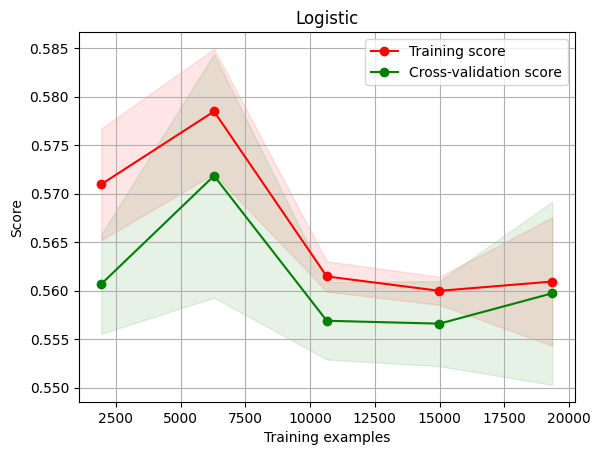

done with Logistic
Fitting Random Forest
CV Random Forest


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   3.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] END .................................................... total time=   3.5s
[CV] END .................................................... total time=   3.5s
[CV] END .................................................... total time=   3.5s
[CV] END .................................................... total time=   3.5s
Accuracy: 0.810061
AUC Score: 0.908387
CV Score: min - 0.739663, max - 0.754616, mean - 0.745733, std – 0.005213
Random Forest


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.5s finished


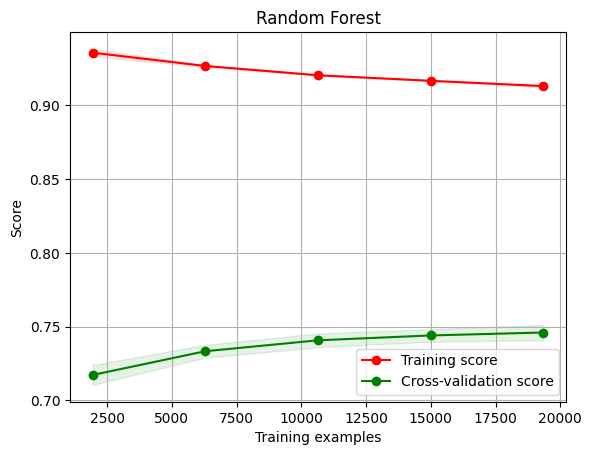

done with Random Forest
Fitting NN
CV NN


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   2.8s
Accuracy: 0.530217
AUC Score: 0.541567
CV Score: min - 0.499795, max - 0.540880, mean - 0.519337, std – 0.014402
NN


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.3s finished


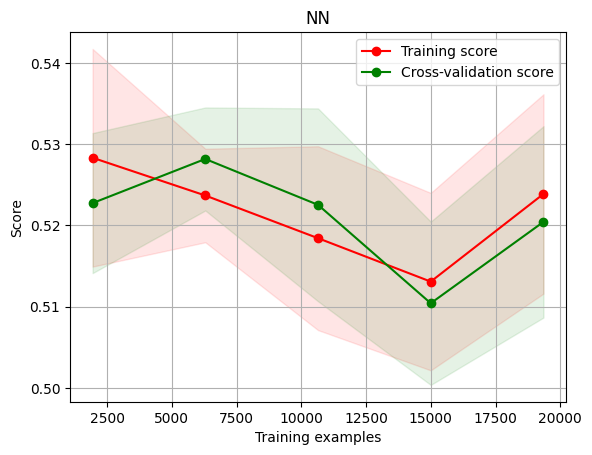

done with NN
Fitting Xgboost
CV Xgboost


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.7s
Accuracy: 0.700976
AUC Score: 0.769476
CV Score: min - 0.744458, max - 0.757376, mean - 0.753906, std – 0.004797
Xgboost


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s finished


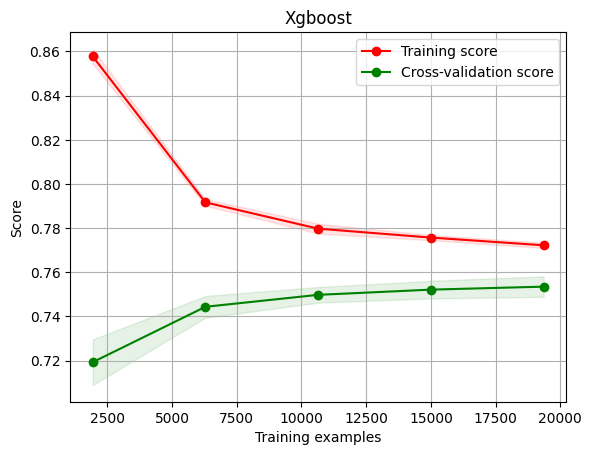

done with Xgboost


In [ ]:
# Create classifiers
lr = LogisticRegression()
rfc = RandomForestClassifier(n_estimators=100, max_depth=19, min_samples_split=25, max_features=0.2, min_samples_leaf=2)
mlpc = MLPClassifier(hidden_layer_sizes=(8,8), batch_size=200, activation='tanh', solver='lbfgs', alpha=1.6384)
xgb_clf = xgboost.XGBClassifier()
#train, test, labels_train, labels_test
for clf, name in [
                  (lr, 'Logistic'),
                  (rfc, 'Random Forest'),
                  (mlpc, 'NN'),#  так как не получилось построить графики объяснений значений в точках, для NN было принято решение построить для случайного леса.
                  (xgb_clf, "Xgboost")
                  ]:

    fit(name, clf, train, labels_train)
    print(name)
    plot_learning_curve(clf, name, train, labels_train)
    plt.show()
    print('done with ' + name)

In [ ]:
!pip install shap
!pip install lime
import shap
import lime
import lime.lime_tabular
from lime import submodular_pick
from sklearn.metrics import f1_score

     |████████████████████████████████| 371 kB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509240 sha256=7ceaf4891245f885e3341b0fe8f42bf26ccae1b8dacdcef822aa34032148f4f6
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap
     |████████████████████████████████| 275 kB 6.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=70f10da438961117181c52dcb5fcd99af76cb7fe9079e91c8f3a6a8a72de876f
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
#test, labels_train, labels_test 
classifiers = [('Random Forest', rfc), ("Logistic regression", lr), ("Xgboost", xgb_clf), ('NN', mlpc)]
print("Model accuracies")
for name, clf in classifiers:
    print("Accuracy {1:20s} {0:.5f}".format(accuracy_score(labels_test, clf.predict(test)),name))
    print("F1 {1:20s} {0:.5f}".format(f1_score(labels_test, clf.predict(test)),name))

Model accuracies
Accuracy Random Forest        0.68915
F1 Random Forest        0.69471
Accuracy Logistic regression  0.52910
F1 Logistic regression  0.54606
Accuracy Xgboost              0.68585
F1 Xgboost              0.68883


#Сравнить важность признаков, получаемую с помощью SHAP с важностью признаков, получаемую с помощью модели на основе ансамбля деревьев решений. Прокомментировать результат (Есть ли разница? Можете ли вы это объяснить?). 

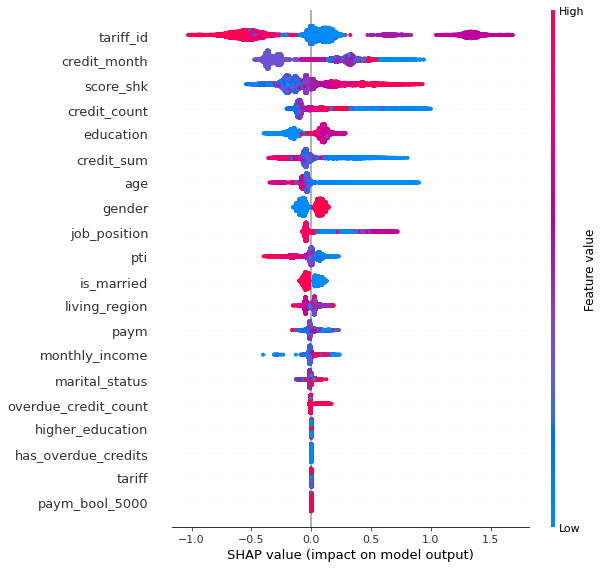

In [ ]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(train)
shap.summary_plot(shap_values, train, feature_names)

##Выводы: Как видно из графика выше, что чем меньше tariff_id(мы с ребятами по совещались и решили, что это закодированная процентная ставка) тем больше вероятнсоть, что клиент откроет кредит в банке. Так же чем больше внутреняя скоринговая оценка банка, тем больше вероятность, что клиент возьмёт в банке кредит(ИМХО типо постоянные клиенты, которые умеют уже внутреннею  оценку). Так же при увелечении суммы кредита и увелечения возраста, вероятность взятия кридита уменьшается(ИМХО по поводу возраста, что тинькофф молодёжный/современный банк, и люди в возрасте не склонны менять свои привычки). Так же мы видем, что образование так же влияет, что чем хуже образование, то вероятность взятия кридита меньше, а чем лучше образование, то больше.

Text(0.5, 1.0, 'XGB feature importance')

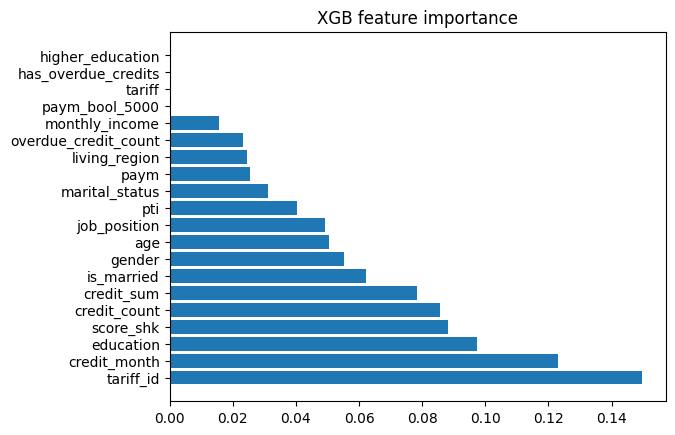

In [ ]:
import operator
# feature importance for XGBoost classifier
fi = {n:v for n,v in zip(feature_names,xgb_clf.feature_importances_.T)}
sorted_fi = sorted(fi.items(), key=operator.itemgetter(1))

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(range(len(sorted_fi)), [v[1] for v in sorted_fi], align='center')
ax.set_yticks(range(len(sorted_fi)))
ax.set_yticklabels([v[0] for v in sorted_fi])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('XGB feature importance')

##Выводы: XGB показывает, что самые важные признаки это tarrif_id, credit_month, education -- что вполне логично.

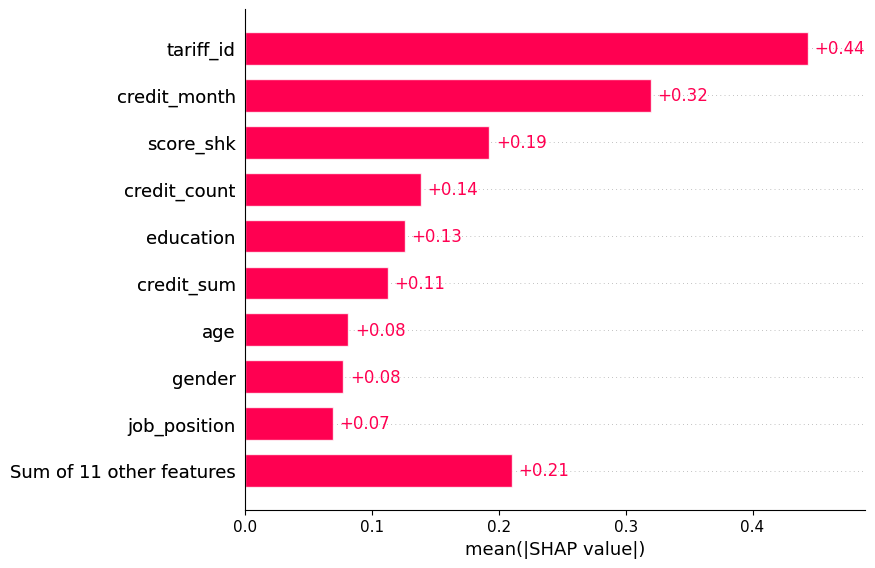

In [ ]:
explainer = shap.Explainer(xgb_clf, feature_names=feature_names)
shap_values = explainer(train)
shap.plots.bar(shap_values)

##Выводы: SHAPE показывает, что самые важные признаки это tarrif_id, credit_month, score_shk -- что вполне логично.

##Выводы: Если обобщать важность признаков по SHAPE и XGB, то в общем и целлом они выдают похожие результаты, примерно для ТОП 5 признаков по важности, что кажется, довольно закономерным для данной задачи.

#Среди 3 методов, выбрать один, который обеспечивает наилучшее качества решения. Проанализировать SHAP-values для всего набора данных в целом. Меняется ли существенно важность признаков внутри класса и между классами? Какие признаки наиболее важны?

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_clf)
exp_array =  shap.sample(test, 100)
shap_values = explainer.shap_values(exp_array)
shap.force_plot(explainer.expected_value, shap_values, exp_array, feature_names=feature_names)

##Вывод: выше показан график, на котором видно какой эффект вносит credit_month (срок кредитования) в зависмости от tariff_id (идентификационный номер тарифа), тут видно что при низких тарифах(т.е. маленькая процентная ставка) и большом сроке клиент выберет скорее всего тинькофф банк.

#Для того же метода, что и в вопросе выше, выбрать 2 примера из разных классов, где модель дает правильный ответ, и 2 примера из разных классов, где модель ошибается. Проанализировать эти примеры для всех 3 моделей с помощью SHAP. Похожи ли объяснения? (Внимание: 4 картинки * 3 модели = 12 примеров).
Примеры брать из тестового набора данных.

In [ ]:
class0 = test[:,0][labels_test==0]
false_0 = test[labels_test==0][np.argmin(class0)]
false_0_id = np.where((test == false_0).sum(axis=1) == 20)[0][0] # 10
true_0 = test[labels_test==0][np.argmax(class0)]
true_0_id = np.where((test == true_0).sum(axis=1) == 20)[0][0] # 1

class1 = test[:,1][labels_test==1]
false_1 = test[labels_test==1][np.argmin(class1)]
false_1_id= np.where((test == false_1).sum(axis=1) == 20)[0][0] # 564
true_1 = test[labels_test==1][np.argmax(class1)]
true1_id= np.where((test == true_1).sum(axis=1) == 20)[0][0] # 834


In [ ]:
print(false_0_id, true_0_id, false_1_id, true1_id)

10 1 564 834


#XBoost

In [ ]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(test[[1, 10, 564, 834],:])

In [ ]:
rid, pid = (0, 1)
pred_label = xgb_clf.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, xgb_clf.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rid], test[pid], feature_names=feature_names)

True class 0, predicted one is 0 (with P = 0.78)


###В данном случае большая вероятность, что клиент не возьмёт кредит в тинькове, потому что низкая внутреняя оценка, средняя сумма кредита, большой возраст.

In [ ]:
rid, pid = (1, 10)
pred_label = xgb_clf.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, xgb_clf.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rid], test[pid], feature_names=feature_names)

True class 0, predicted one is 1 (with P = 0.56)


###В данном случае модель ошиблась, потому что тут не большая сумма кредита, низкая процентная ставка и небольшой срок кредита.

In [ ]:
rid, pid = (2, 564)
pred_label = xgb_clf.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, xgb_clf.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rid], test[pid], feature_names=feature_names)

True class 1, predicted one is 1 (with P = 0.95)


###В данном случае модель сделала правильное предсказание,  потому что тут, все факторы за то, что клиент возьмёт кредит.

In [ ]:
rid, pid = (3, 834)
pred_label = xgb_clf.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, xgb_clf.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rid], test[pid], feature_names=feature_names)

True class 1, predicted one is 1 (with P = 0.87)


###Тут объяснить почему модель ошиблась исходя из объективых факторов сложно, сокрее всего просто не линейное поведение пользователя, или для него были важны другие признкаки, которые в модели не учитывались.

#Linear

In [ ]:
explainer = shap.LinearExplainer(lr, train)
shap_values = explainer.shap_values(test[[1, 10, 564, 834],:])

In [ ]:
rid, pid = (0, 1)
pred_label = lr.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, lr.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rid], test[pid], feature_names=feature_names)

True class 0, predicted one is 0 (with P = 0.52)


Тут клиент не взял кредит, как показывает модель, то вероятнсоть была примерно 50 процентов, какой из выше перечисленных фактором стал определяющим, сложно сказать.

In [ ]:
rid, pid = (1, 10)
pred_label = lr.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, lr.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rid], test[pid], feature_names=feature_names)

True class 0, predicted one is 1 (with P = 0.52)


Тут тоже клиент не взял кредит, но модель предсказала, что он возьмёт, модель сделала вывод на основе признаках: регион и сумма месячного платежа, что в данном случае это клиент банка.

In [ ]:
rid, pid = (2, 564)
pred_label = lr.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, lr.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rid], test[pid], feature_names=feature_names)

True class 1, predicted one is 1 (with P = 0.51)


Вообще для линейной модели оказался очень важный признак это сумма платежа, тут она не большая, поэтому модель посчитала, что клиент возьмёт кредит и он взял кредит.

In [ ]:
rid, pid = (3, 834)
pred_label = lr.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, lr.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rid], test[pid], feature_names=feature_names)

True class 1, predicted one is 0 (with P = 0.53)


А тут сумма платежа была больше поэтому модель предсказала, что он не возьмёт кредит, а клиент взял кредит.

#NN

УСТАРЕЛО(Для простой нейронной сети эксплейнер отказывается работать. Две ячейки ниже, показывают, что именно не заработало.)

#UPD: удалось заставить работать(правда как-то криво и не понятно), в 26.11 в 22:48

In [ ]:
explainer = shap.KernelExplainer(mlpc.predict_proba, shap.sample(train, 1000))
shap_values = explainer.shap_values(test[[1, 10, 564, 834],:])

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
rid, pid = (0, 1)
pred_label = mlpc.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, mlpc.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][rid], test[pid], feature_names=feature_names)

True class 0, predicted one is 1 (with P = 0.52)


Тут не интуитивный вывод получается, при хорошей ЗП, клиент берёт кредит, а должен был не брать.

In [ ]:
rid, pid = (1, 10)
pred_label = mlpc.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, mlpc.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][rid], test[pid], feature_names=feature_names)

True class 0, predicted one is 1 (with P = 0.57)


Тут не интуитивно, и у нейронки плохое качество, поэтому она много ошибается и  сложно делать выводы почему она ошиблась.

In [ ]:
rid, pid = (2, 564)
pred_label = mlpc.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, mlpc.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][rid], test[pid], feature_names=feature_names)

True class 1, predicted one is 0 (with P = 0.51)


Тут не интуитивно, и у нейронки плохое качество, поэтому она много ошибается и  сложно делать выводы почему она ошиблась.

In [ ]:
rid, pid = (3, 834)
pred_label = mlpc.predict(test[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(labels_test[pid], 
      pred_label, mlpc.predict_proba(test[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][rid], test[pid], feature_names=feature_names)

True class 1, predicted one is 0 (with P = 0.51)


Тут не интуитивно, и у нейронки плохое качество, поэтому она много ошибается и  сложно делать выводы почему она ошиблась.

In [ ]:
rid, pid = (0, 1)
pred_label = rf_clf.predict(X_test.iloc[[pid],:])[0]
print("True class {0:d}, predicted one is {1:d} (with P = {2:.2f})".format(y_test.iloc[pid], 
      pred_label, rf_clf.predict_proba(X_test.iloc[[pid],:])[0][pred_label]))
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][rid], X_test.iloc[pid])

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(encoded_train, labels_train)
accuracy_score(labels_test, rf.predict(encoder.transform(test)))

In [ ]:
predict_fn = lambda x: rfc.predict_proba(encoder.transform(x)).astype(float)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=feature_names, class_names=class_names,
                                                   categorical_features=categorical_features_indices, 
                                                   categorical_names=categorical_names)

In [ ]:
n_explanations = 6

In [ ]:
#exp = explainer.explain_instance(true_0, predict_fn, num_features=n_explanations)
#exp.show_in_notebook(show_all=False)

In [ ]:
#exp = explainer.explain_instance(true_1, predict_fn, num_features=n_explanations)
#exp.show_in_notebook(show_all=False)

In [ ]:
exp = explainer.explain_instance(true_1, predict_fn, num_features=n_explanations)
exp.show_in_notebook(show_all=False)